# Dogs vs. Cats

Creating an algorithm to distinguish dogs from cats using Tensorflow

Link: <a href="https://www.kaggle.com/c/dogs-vs-cats/data">Kaggle challenge</a>

### Libraries

In [1]:
from os import listdir, makedirs
from os.path import isfile, join, exists
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Global variables

In [2]:
# Informations about image
width = 112
height = 112
depth = 1
process_image_by_tensorflow = True

### Helper functions

This sections is necessary to define small blocks of code that will show many times in the algorithm to process infos.

In [3]:
# This function will show at digit.
def show_image(arr, label):
    plt.imshow(arr)
    plt.title("Animal: {}".format(label))
    return plt

# Getting informations picture and setting in an array.
def get_data_image(folder):
    path = folder
    files = [f for f in listdir(path) if isfile(join(path, f))]

    data = []
    for item in files:
        result = 1 if 'dog' in item else 0
        data.append([np.asarray(Image.open(folder + item)),result])
    return data

### Process images functions

In [4]:
# Resizing dimensions of image.
def resize_image(img, width, height, directory_destiny):
    if not exists(directory_destiny):
        makedirs(directory_destiny)
    
    # open an image file   
    # adjust width and height to your needs
    # use one of these filter options to resize the image
    # convert 'L' is monochrome
    new_image = Image.open(img).resize((width, height), Image.NEAREST).convert('L')
    #new_image = new_image.convert('1')
    new_image.save(directory_destiny + img.split("/")[1])
    

# This method will select all images in a directory and resize it in another directory.
def process_resize_images(directory, directory_destiny, width, height):
    files = [f for f in listdir(directory) if isfile(join(directory, f))]
    for item in files:
        resize_image(directory + item, width, height, directory_destiny)

# This method will resize and put the image information into an array
def process_resize_images_by_tensorflow(directory, width, height, total):
    images = []
    labels = []
    with tf.Session() as sess:
        files = [f for f in listdir(directory) if isfile(join(directory, f))]
        i = 0
        for item in files:
            if i == total:
                break
            image = tf.image.decode_jpeg(tf.read_file(directory + item), channels=depth)
            image = tf.image.resize_images(image, [width, height])
            img = sess.run(image)
            labels.append(1 if 'dog' in item else 0)
            images.append(np.reshape(img, (width, height)))
            i += 1
    return images, labels
    

### Model functions

In [5]:
# This function contains the train method and predict of tensorflow
def cnn_model(features, labels, mode):
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, width, height, depth])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, int(width/4) * int(height/4) * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=2)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Loading the training and test data set

In code bellow, there are two examples of data, one dog and one cat. It will convert images in numpy array

In [6]:
img1 = np.asarray(Image.open('train/cat.0.jpg'))
print (img1.shape)

img2 = np.asarray(Image.open('train/dog.1.jpg'))
print (img2.shape)

(374, 500, 3)
(499, 327, 3)


<module 'matplotlib.pyplot' from '/anaconda/envs/myenv/lib/python3.5/site-packages/matplotlib/pyplot.py'>

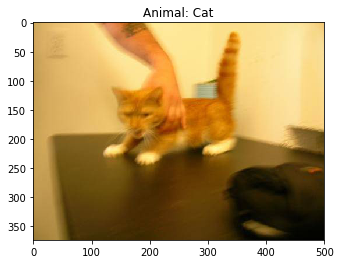

In [7]:
# show cat image
show_image(img1, 'Cat')

<module 'matplotlib.pyplot' from '/anaconda/envs/myenv/lib/python3.5/site-packages/matplotlib/pyplot.py'>

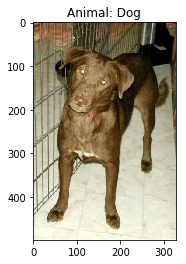

In [8]:
# show cat image
show_image(img2, 'Dog')

Let's resize the image to decrease the dimensions of the image and thereby slow down processing.

In [9]:
data, label = process_resize_images_by_tensorflow('train/', width, height, 6000) 
print (len(data))
print (len(label))

6000
6000


Showing informations about image like array and label

In [10]:
print("Format image: " + str(data[0].shape) + " Label: " + str(label[0]))
print("Format image: " + str(data[999].shape) + " Label: " + str(label[1]))

Format image: (112, 112) Label: 1
Format image: (112, 112) Label: 1


Showing dog's image after resize process.

<module 'matplotlib.pyplot' from '/anaconda/envs/myenv/lib/python3.5/site-packages/matplotlib/pyplot.py'>

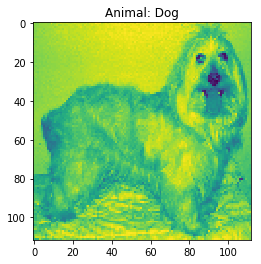

In [11]:
show_image(data[2], "Dog" if label[2] == 1 else "Cat")

### Training model with dogs and cats images

In [13]:
arr_images = np.array(data)
label =  np.array(label).astype(int)

In [9]:
###################################
####### Create the Estimator ######
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model, model_dir="/home/msgrubler/Git/Others/Dogs-Cats/convnet_model")

##########################################
###### Set up logging for predictions
###### Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_evaluation_master': '', '_num_worker_replicas': 1, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0c3435abe0>, '_global_id_in_cluster': 0, '_master': '', '_service': None, '_session_config': None, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_device_fn': None, '_save_summary_steps': 100, '_log_step_count_steps': 100, '_is_chief': True, '_keep_checkpoint_max': 5, '_task_id': 0, '_model_dir': '/home/msgrubler/Git/Others/Dogs-Cats/convnet_model', '_train_distribute': None, '_task_type': 'worker', '_tf_random_seed': None}


In [14]:
##############################
####### Train the model ######
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": arr_images},
    y=label,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

mnist_classifier.train(
    input_fn=train_input_fn,
    steps=700,
    hooks=[logging_hook])
###############################

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_id': 0, '_train_distribute': None, '_service': None, '_num_ps_replicas': 0, '_task_type': 'worker', '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_model_dir': '/home/msgrubler/Git/Others/Dogs-Cats/convnet_model', '_save_checkpoints_steps': None, '_tf_random_seed': None, '_session_config': None, '_log_step_count_steps': 100, '_is_chief': True, '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4c78111f98>, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_device_fn': None}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/msgrubler/Git/Others/Dogs-Cats/convnet_model/model.ckpt-1331
INFO:tensorflow:Running

INFO:tensorflow:loss = 0.6598516, step = 1432 (421.555 sec)
INFO:tensorflow:Saving checkpoints for 1458 into /home/msgrubler/Git/Others/Dogs-Cats/convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.6870155  0.31298453]
 [0.20994243 0.7900576 ]
 [0.2183081  0.7816919 ]
 [0.5401662  0.4598338 ]
 [0.24402374 0.7559763 ]
 [0.6111774  0.38882253]
 [0.59964794 0.4003521 ]
 [0.7519384  0.24806158]
 [0.59752434 0.40247563]
 [0.58606744 0.4139326 ]
 [0.5542991  0.4457008 ]
 [0.33192435 0.6680756 ]
 [0.48273423 0.5172658 ]
 [0.5302428  0.46975714]
 [0.5792665  0.42073348]
 [0.71064365 0.28935635]
 [0.5906487  0.4093513 ]
 [0.72564167 0.2743583 ]
 [0.8070259  0.19297417]
 [0.7523229  0.24767712]
 [0.78511864 0.21488136]
 [0.38408372 0.6159163 ]
 [0.4838122  0.51618785]
 [0.7623809  0.23761912]
 [0.61569357 0.3843065 ]
 [0.4571605  0.5428395 ]
 [0.45643455 0.54356545]
 [0.19035125 0.80964875]
 [0.21108994 0.7889101 ]
 [0.24929771 0.7507023 ]
 [0.93239576 0.06760427]
 [0.6606821  0.339317

INFO:tensorflow:loss = 0.53710294, step = 1632 (421.705 sec)
INFO:tensorflow:probabilities = [[0.78170633 0.2182937 ]
 [0.22221129 0.7777887 ]
 [0.26117513 0.7388248 ]
 [0.48369482 0.51630515]
 [0.40575102 0.59424895]
 [0.17053051 0.82946944]
 [0.86577785 0.13422215]
 [0.2640495  0.73595047]
 [0.64987826 0.35012168]
 [0.47957057 0.52042943]
 [0.36888564 0.63111436]
 [0.30113652 0.6988635 ]
 [0.41057676 0.5894232 ]
 [0.6362908  0.36370918]
 [0.59499574 0.40500432]
 [0.3835151  0.6164849 ]
 [0.21236615 0.7876339 ]
 [0.58449185 0.4155082 ]
 [0.14553122 0.85446876]
 [0.53380716 0.46619284]
 [0.53296614 0.4670339 ]
 [0.4232788  0.57672125]
 [0.58293873 0.41706133]
 [0.83902323 0.16097674]
 [0.66843987 0.33156016]
 [0.5941886  0.40581143]
 [0.5855219  0.4144781 ]
 [0.21394208 0.7860579 ]
 [0.3513115  0.64868844]
 [0.19924219 0.80075777]
 [0.2866198  0.7133802 ]
 [0.3845127  0.6154873 ]
 [0.49101022 0.5089898 ]
 [0.23213176 0.7678682 ]
 [0.00524193 0.99475807]
 [0.88528556 0.11471452]
 [0.497

INFO:tensorflow:loss = 0.56291896, step = 1832 (1472.508 sec)
INFO:tensorflow:Saving checkpoints for 1843 into /home/msgrubler/Git/Others/Dogs-Cats/convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.12311372 0.87688625]
 [0.8530995  0.14690046]
 [0.6969223  0.3030777 ]
 [0.67007685 0.32992318]
 [0.24209318 0.7579068 ]
 [0.514354   0.485646  ]
 [0.51029074 0.4897093 ]
 [0.6901177  0.30988228]
 [0.32680836 0.67319167]
 [0.3261836  0.6738164 ]
 [0.20591305 0.794087  ]
 [0.89220244 0.1077975 ]
 [0.28398797 0.71601206]
 [0.27439725 0.72560275]
 [0.16510496 0.8348951 ]
 [0.2196846  0.78031546]
 [0.6162708  0.38372922]
 [0.3133286  0.68667144]
 [0.30501416 0.69498587]
 [0.22277388 0.77722615]
 [0.71602994 0.28397003]
 [0.5450128  0.45498726]
 [0.2672957  0.73270434]
 [0.8376048  0.16239521]
 [0.9750344  0.02496562]
 [0.17223176 0.8277682 ]
 [0.3648078  0.63519216]
 [0.63497484 0.36502513]
 [0.7265939  0.2734061 ]
 [0.51548856 0.48451144]
 [0.03660538 0.9633946 ]
 [0.5783123  0.4216

INFO:tensorflow:Saving checkpoints for 2017 into /home/msgrubler/Git/Others/Dogs-Cats/convnet_model/model.ckpt.
INFO:tensorflow:Saving checkpoints for 2031 into /home/msgrubler/Git/Others/Dogs-Cats/convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.5247905.


### Predicting images

After training the model, it is necessary test the new CNN model builded.

In [10]:
result = process_resize_images_by_tensorflow('test/', width, height, 2500) 
arr_result = np.array(result[0])

In [21]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
  x={"x": arr_result},
  num_epochs=1,
  shuffle=False)
test_results = mnist_classifier.predict(input_fn=predict_input_fn)

In [22]:
results = [res['classes'] for res in test_results]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/msgrubler/Git/Others/Dogs-Cats/convnet_model/model.ckpt-2031
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [26]:
print (len(results))

2500


<module 'matplotlib.pyplot' from '/anaconda/envs/myenv/lib/python3.5/site-packages/matplotlib/pyplot.py'>

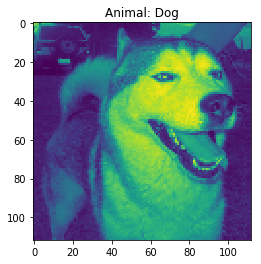

In [31]:
show_image(arr_result[2000], "Dog" if results[2000] == 1 else "Cat")

### Genereting the new dataset with predictions in a csv file

In [30]:
solution = pd.DataFrame({
    'id': np.array([i for i in range(1, len(results) + 1)]), 
    'label' : np.array(results).astype(int) 
})

print(solution.shape)
solution.to_csv("solution.csv", index=False)

(2500, 2)
